# Topic Modeling for Finding Trend Bias between News & Social Media

## 1. News Data

In [227]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 300
plt.style.use('ggplot')
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [228]:
# import data

df=pd.read_csv('news_data.txt', sep = "\n", header=None, error_bad_lines=False)
X = pd.Series(np.asarray(df).ravel())
print(len(X))
X[:10] #sample

7371


0    We teamed up with The Wirecutter to come up wi...
1    In the absence of any disclosures from Mr. Tru...
2    Simple tips to follow if you think your person...
3    European authorities have agreed to disburse $...
4    The new debt relief law is stirring colonial r...
5    Photos posted on @nytimes during the last week...
6     David Phillips provides our first Saturday ch...
7     Harmony to soothe the soul. Harmony to soothe...
8    A look at some of the year’s most striking Sty...
9    From Times Square to the web, we asked people ...
dtype: object

## 1.1. Latent Dirichlet Allocation (LDA)

### Topic-Word: A collection of distributions on words (topics).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
documents = X.copy()
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
no_topics = 8

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print("\nLDA Topic Distributions:\n")
display_topics(lda, tf_feature_names, no_top_words)

def plot_important_features(coefficients, feature_names, top_n=10, ax=None):
    if ax is None:
        ax = plt.gca()
    coef = np.ones(len(coefficients))
    Sum = sum(coefficients)
    for i in range(len(coefficients)):
        coef[i] = coefficients[i]/Sum
        
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds], color='orange')
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

feature_names = np.array(tf_vectorizer.get_feature_names())
n_components = 4


Distributions Plot:



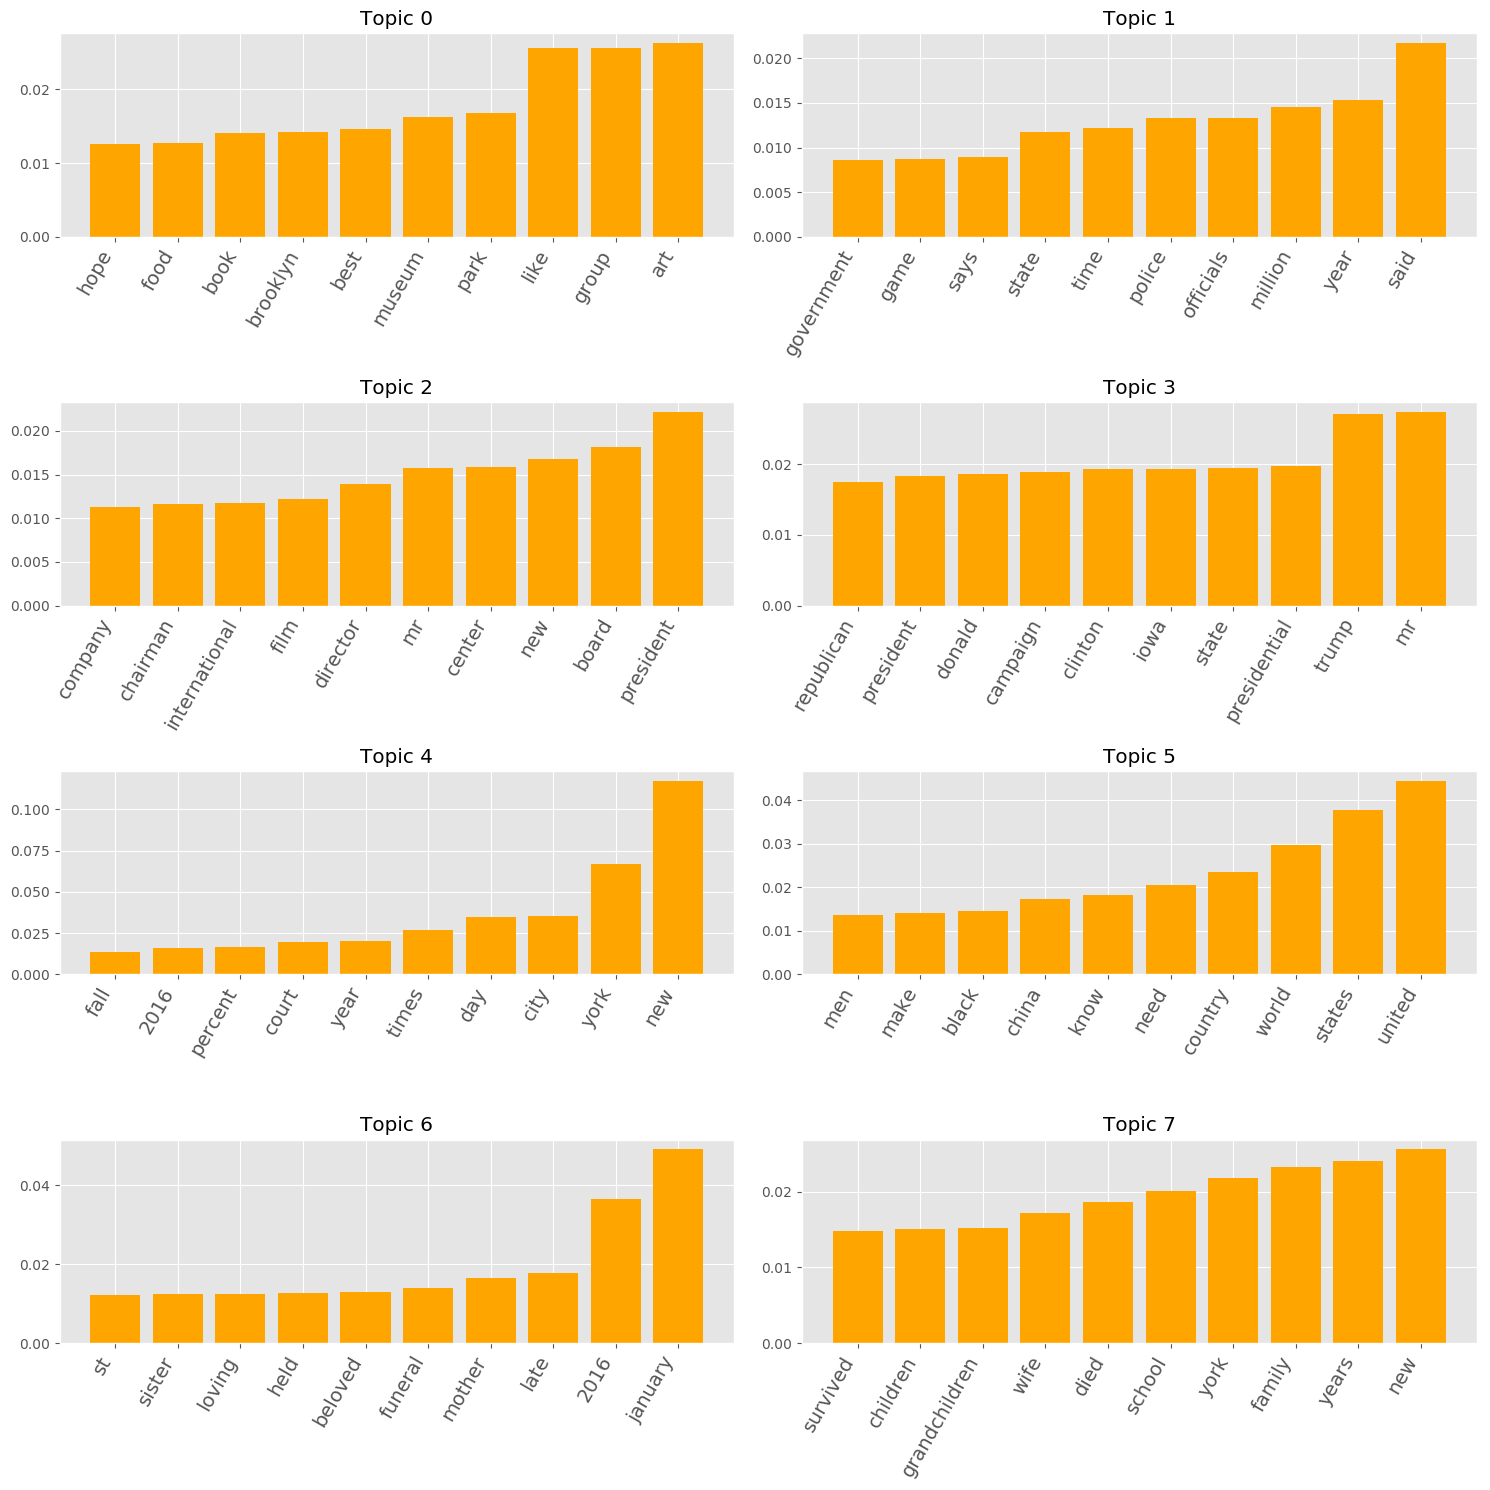

In [245]:
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 15))
count=-1
print("\nDistributions Plot:\n")
for ax, coef in zip(axes.ravel(), lda.components_):
    count+=1
    ax.set_title("Topic %s" %count)
    
    plot_important_features(coef, feature_names, ax=ax)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.tight_layout()

# topics_map = {
#                 1 : 'General',
#                 2 : 'Business',
#                 3 : 'Politics',
#                 4 : 'Health',
#                 5 : 'World',
#                 6 : 'General',
#                 7 : 'Technology',
#                 8 : 'Economy'
#                 }
# print('LDA Topics Index Map:')
# for i in topics_map:
#     print(i,":",topics_map[i])

### Document-Topic: A distribution on topics for each document.


NMF average distributions on topics 0-7 for all documents:



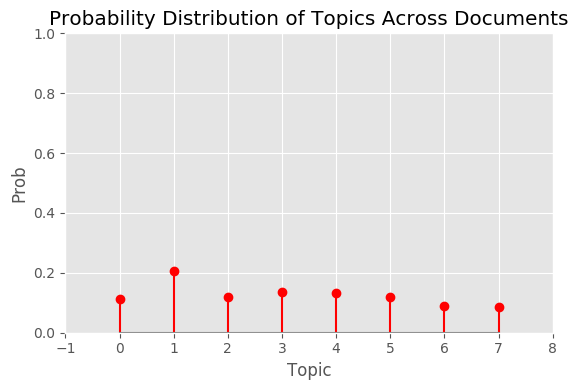

In [230]:
doc_topic_dist_unnormalized = np.matrix(lda.transform(tf))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

where_are_NaNs = np.isnan(doc_topic_dist)
doc_topic_dist[where_are_NaNs] = 0
doc_topic_dist_mean = doc_topic_dist.mean(axis=0)

doc_topic_dist = doc_topic_dist_mean/doc_topic_dist_mean.sum(axis=1)

plt.rcParams["figure.dpi"] = 100
plt.stem(np.asarray(doc_topic_dist)[k,:], linefmt='r-', markerfmt='ro')
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.ylabel("Prob")
plt.title("Probability Distribution of Topics Across Documents")
plt.xlabel("Topic")

print('\nNMF average distributions on topics 0-7 for all documents:\n')
plt.tight_layout()
plt.show()

## 1.2. Non-negative Matrix Factorization (NMF)


NMF Topic Distributions:

Topic 0:
new york city times past jersey year appeared articles mayor
Topic 1:
day know need start end week january stories 2016 trip
Topic 2:
january 2016 family wife years ny beloved husband died loving
Topic 3:
trump cruz donald ted mr republican iowa presidential senator debate
Topic 4:
fall 2016 men collection designs looks winter january print fashion
Topic 5:
said year state united states people american government officials president
Topic 6:
international tribune herald archives french dies president paris united forces
Topic 7:
clinton sanders hillary bernie iowa campaign senator democratic presidential mrs

Distributions Plot:



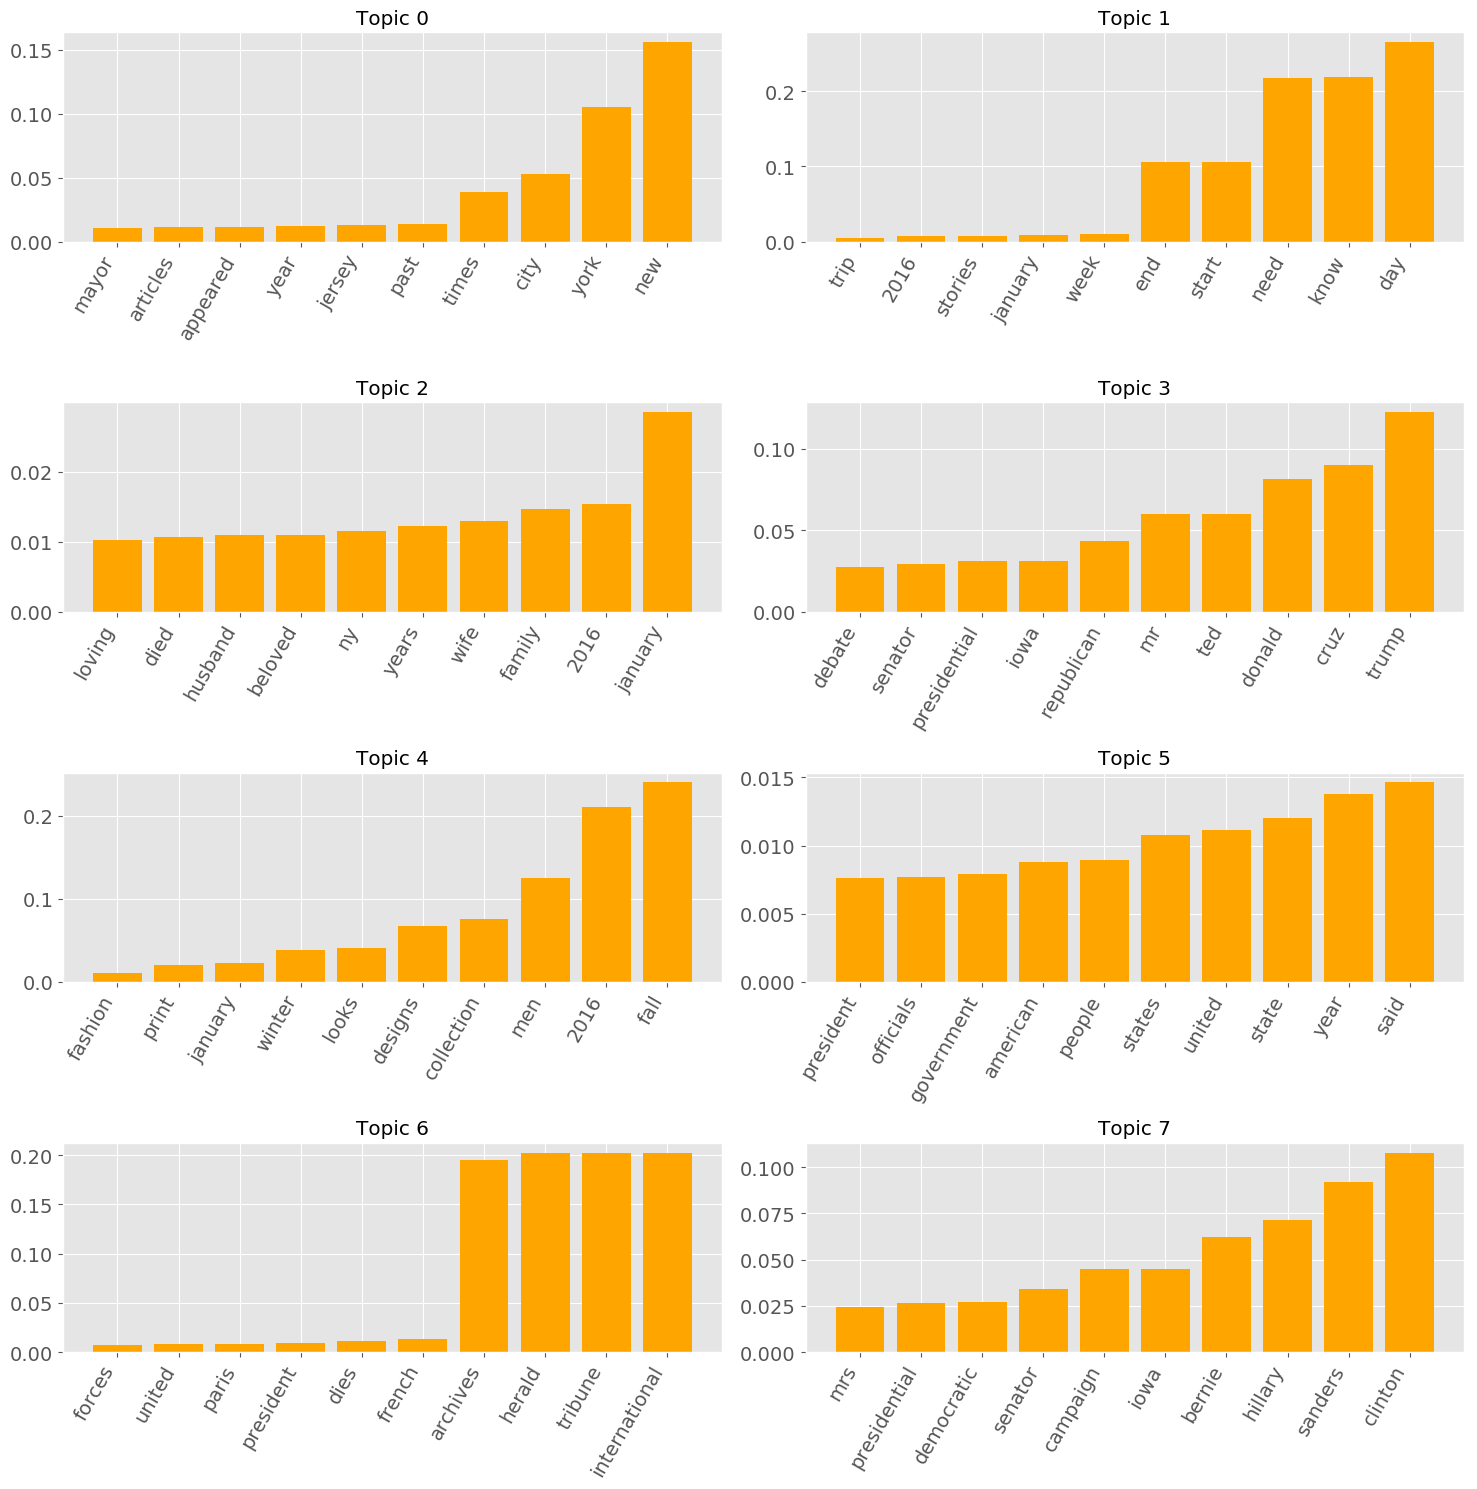

In [248]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 8

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

no_top_words = 10
print("\nNMF Topic Distributions:\n")
display_topics(nmf, tfidf_feature_names, no_top_words)

feature_names = np.array(tfidf_vectorizer.get_feature_names())
n_components = 4
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 15))
count=-1
print("\nDistributions Plot:\n")
for ax, coef in zip(axes.ravel(), nmf.components_):
    count+=1
    ax.set_title("Topic %s" %count)
    plot_important_features(coef, feature_names, ax=ax)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.tight_layout()

### 1.3. Document Distributions

/Users/moorissatjokro/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide



NMF average distributions on topics 0-7 for all documents:



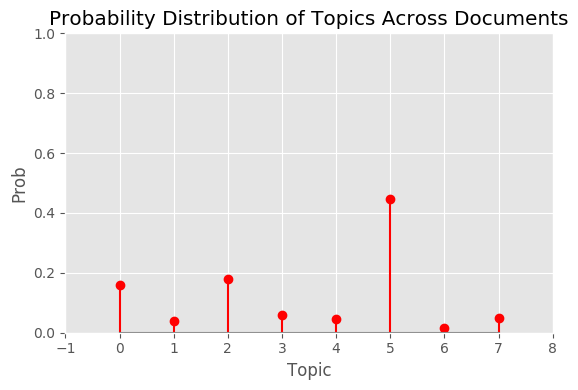

In [232]:
doc_topic_dist_unnormalized = np.matrix(nmf.transform(tf))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

where_are_NaNs = np.isnan(doc_topic_dist)
doc_topic_dist[where_are_NaNs] = 0
doc_topic_dist_mean = doc_topic_dist.mean(axis=0)

doc_topic_dist = doc_topic_dist_mean/doc_topic_dist_mean.sum(axis=1)

plt.rcParams["figure.dpi"] = 100
plt.stem(np.asarray(doc_topic_dist)[k,:], linefmt='r-', markerfmt='ro')
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.ylabel("Prob")
plt.title("Probability Distribution of Topics Across Documents")
plt.xlabel("Topic")

print('\nNMF average distributions on topics 0-7 for all documents:\n')
plt.tight_layout()
plt.show()

## 2. Twitter Data

In [126]:
# import data

df=pd.read_csv('twitter_data.txt', sep = "\n", header=None, error_bad_lines=False)

D = pd.Series(np.asarray(df).ravel())
print(len(D))
D[:10] #sample

33039


b'Skipping line 49: expected 1 fields, saw 2\nSkipping line 58: expected 1 fields, saw 2\nSkipping line 1086: expected 1 fields, saw 2\nSkipping line 1087: expected 1 fields, saw 2\nSkipping line 1781: expected 1 fields, saw 2\nSkipping line 3227: expected 1 fields, saw 2\nSkipping line 3550: expected 1 fields, saw 2\nSkipping line 4320: expected 1 fields, saw 2\nSkipping line 4322: expected 1 fields, saw 2\nSkipping line 4324: expected 1 fields, saw 2\nSkipping line 4326: expected 1 fields, saw 2\nSkipping line 4328: expected 1 fields, saw 2\nSkipping line 4330: expected 1 fields, saw 2\nSkipping line 4332: expected 1 fields, saw 2\nSkipping line 4334: expected 1 fields, saw 2\nSkipping line 4336: expected 1 fields, saw 2\nSkipping line 4341: expected 1 fields, saw 2\nSkipping line 4343: expected 1 fields, saw 2\nSkipping line 4724: expected 1 fields, saw 2\nSkipping line 5037: expected 1 fields, saw 2\nSkipping line 5436: expected 1 fields, saw 2\nSkipping line 5568: expected 1 field

0    Thank you Louisville, Kentucky- on my way! #MA...
1    RT @ChrisFisher247: Kentucky's class now inclu...
2    RT @DanKarellPreps: Youth soccer players from ...
3    RT @Screenweek: Un viaggio nel Kentucky, dove ...
4    roof over my head n im not staying in kentucky...
5    Steffi Graf ist der Hingucker beim Kentucky-De...
6    Bombou no fim de semana https://t.co/XtPcUh3Kz...
7            RT @MsStBaseballFan: SEC Standings Week 8
8                                        MS State 16-8
9                                         Florida 16-8
dtype: object

## 2.1. Latent Dirichlet Allocation (LDA)

In [142]:
from sklearn.feature_extraction import text 

# taking out any words with length < 3
stopwords = []
for i in Y:
    for j in i.split():
        if len(j)<3:
            stopwords.append(j)
stopwords.extend(['que','los','don','htt','https','por','la','al','se','le','el','30','10','del','amp'])
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)


LDA Topic Distributions:

Topic 0:
2017 youtube love make watch paul say star mark nowplaying
Topic 1:
like day time people free world let going public service
Topic 2:
video great today state job john team international way usa
Topic 3:
american city life live want win robert home look got
Topic 4:
new just york music george big work need south james
Topic 5:
national year park week read did michael museum america story
Topic 6:
news university art says party school man travel review group
Topic 7:
trump good david health years best know black president http

Distributions Plot:



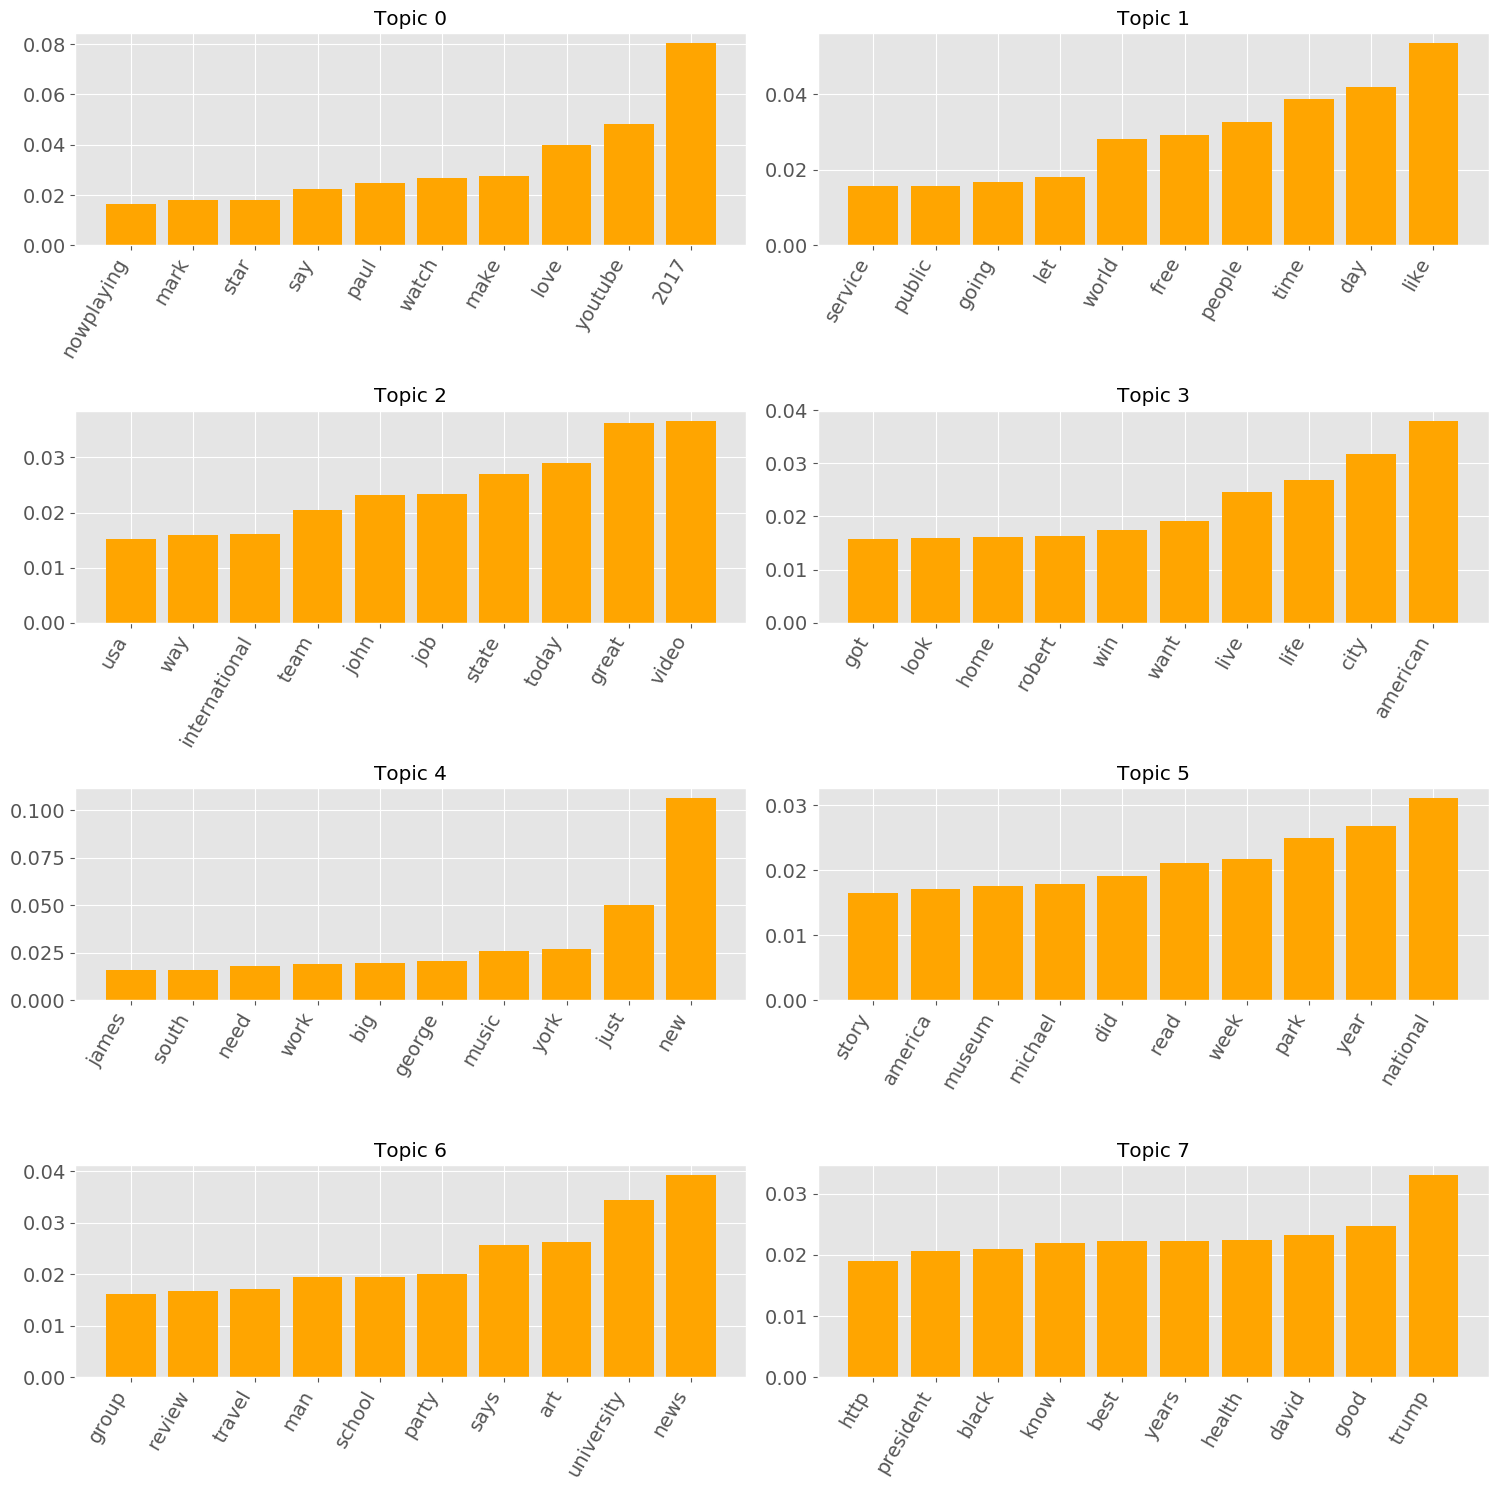

In [249]:
documents = D.copy()
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stop_words)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
no_topics = 8

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, 
                                learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print("\nLDA Topic Distributions:\n")
display_topics(lda, tf_feature_names, no_top_words)

feature_names = np.array(tf_vectorizer.get_feature_names())
n_components = 4
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 15))
count=-1
print("\nDistributions Plot:\n")
for ax, coef in zip(axes.ravel(), lda.components_):
    count+=1
    ax.set_title("Topic %s" %count)
    plot_important_features(coef, feature_names, ax=ax)
plt.tight_layout()

### Document-Topic: A distribution on topics for each document.


LDA average distributions on topics 0-7 for all documents:



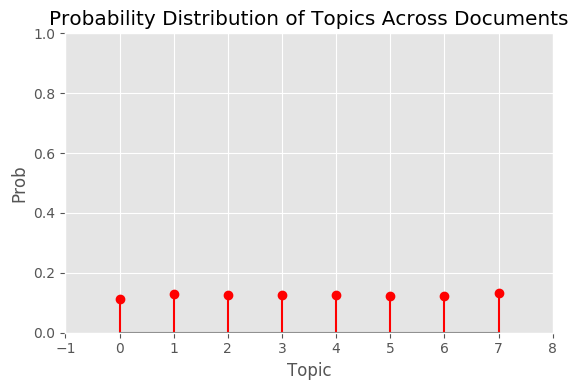

In [221]:
doc_topic_dist_unnormalized = np.matrix(lda.transform(tf))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

where_are_NaNs = np.isnan(doc_topic_dist)
doc_topic_dist[where_are_NaNs] = 0
doc_topic_dist_mean = doc_topic_dist.mean(axis=0)

doc_topic_dist = doc_topic_dist_mean/doc_topic_dist_mean.sum(axis=1)

plt.rcParams["figure.dpi"] = 100
plt.stem(np.asarray(doc_topic_dist)[k,:], linefmt='r-', markerfmt='ro')
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.ylabel("Prob")
plt.title("Probability Distribution of Topics Across Documents")
plt.xlabel("Topic")

print('\nLDA average distributions on topics 0-7 for all documents:\n')
plt.tight_layout()
plt.show()

## 2.2. Non-Negative Matrix Factorization (NMF)

### Topic-Word: A collection of distributions on words (topics).


NMF Topic Distributions:

Topic 0:
the from was that world first has this will are
Topic 1:
and are all more between one from his have just
Topic 2:
for top inc more time social looking vote bts_twt btsbbmas
Topic 3:
you this your are that can what have like not
Topic 4:
with this plan interview get his what more today your
Topic 5:
new york city from jersey year today times club may
Topic 6:
via youtube video nyt liked how neil technology playlist travel
Topic 7:
2017 may spring summer exit festival live jimmy east fashion

Distributions Plot:



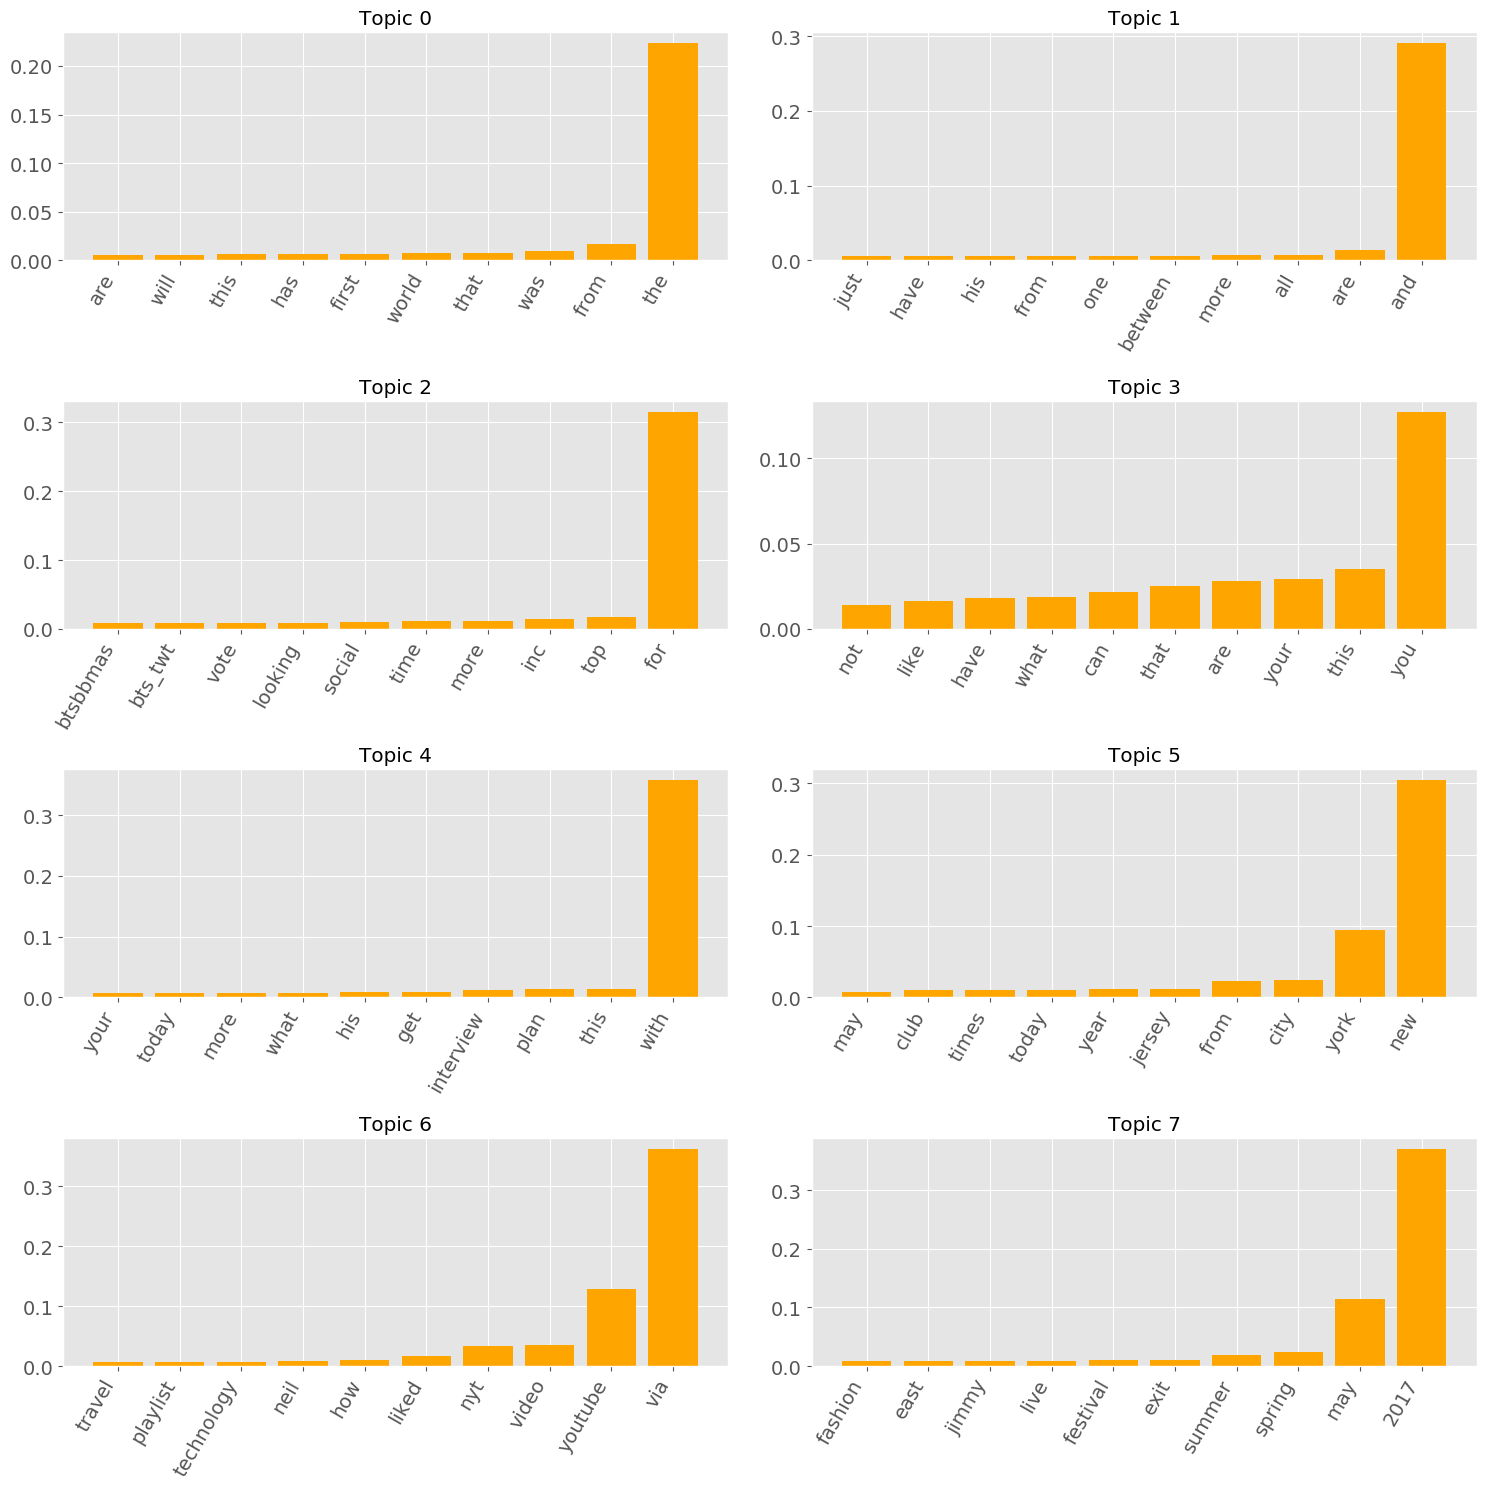

In [250]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 8

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

no_top_words = 10
print("\nNMF Topic Distributions:\n")
display_topics(nmf, tfidf_feature_names, no_top_words)

feature_names = np.array(tfidf_vectorizer.get_feature_names())
n_components = 4
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 15))
count=-1
print("\nDistributions Plot:\n")
for ax, coef in zip(axes.ravel(), nmf.components_):
    count+=1
    ax.set_title("Topic %s" %count)
    plot_important_features(coef, feature_names, ax=ax)
plt.tight_layout()

### Document-Topic: A distribution on topics for each document.

/Users/moorissatjokro/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide



NMF average distributions on topics 0-7 for all documents:



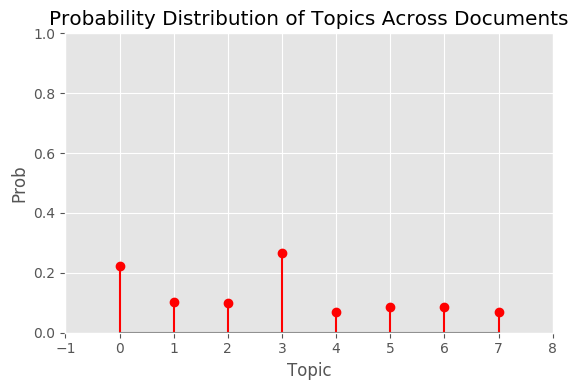

In [223]:
doc_topic_dist_unnormalized = np.matrix(nmf.transform(tf))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

where_are_NaNs = np.isnan(doc_topic_dist)
doc_topic_dist[where_are_NaNs] = 0
doc_topic_dist_mean = doc_topic_dist.mean(axis=0)

doc_topic_dist = doc_topic_dist_mean/doc_topic_dist_mean.sum(axis=1)

plt.rcParams["figure.dpi"] = 100
plt.stem(np.asarray(doc_topic_dist)[k,:], linefmt='r-', markerfmt='ro')
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.ylabel("Prob")
plt.title("Probability Distribution of Topics Across Documents")
plt.xlabel("Topic")

print('\nNMF average distributions on topics 0-7 for all documents:\n')
plt.tight_layout()
plt.show()